# Saddle-to-Saddle Dynamics in Diagonal Linear Networks

In [72]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy

## Construct Data

In [73]:
# -------------------------------
# 1. Hyperparameters & Setup
# -------------------------------
d = 10       # dimension
n = 10       # number of data points
exponent = 1.5  # power for diagonal covariance

# Diagonal entries: sigma_i = i^(-exponent)
cov_diag = np.power(np.arange(1, d+1, dtype=float), -exponent)
X = np.random.multivariate_normal(np.zeros(d), np.diag(cov_diag), size=n)

# # Diagonalize (If \Sigma_xx is coordinate aligned, then the dynamics decouple and Utility Maximization frameowork easily applies)
# U, S, VT = np.linalg.svd(X, full_matrices=False)
# X = U @ np.diag(np.ones_like(S)) @ VT

beta_true = 10 * np.random.randn(d)
y = X @ beta_true

## Construct Diagonal Linear Network Model

Here each element of $\beta_i = \prod_{j=1}^L u_{ij}$ where $u \in \mathbb{R}^{d \times L}$. This network has in total $Ld$ parameters. When $L = 2$ this is the classic two-layer diagonal linear network

In [93]:
# -------------------------------
# 2. Hyperparameters
# -------------------------------
alpha = 5e-1         # initialization scalar
learning_rate = 0.01
max_iters = int(1e5)
tol = 5e-5
L = 2        # depth of network

# -------------------------------
# 2. Initialization
# -------------------------------
weights = [np.sqrt(2) * alpha * np.ones(d) for _ in range(L - 1)] + [np.zeros(d)] # First layers fixed, last zero

# weights = [alpha * np.random.randn(d) for _ in range(L)]  # First layer zero, rest random

# -------------------------------
# 3. Helper Functions
# -------------------------------
def predict(X, weights):
    """
    L-layer diagonal linear network: f(X; w_1, ..., w_L) = X @ (w_1 ∘ w_2 ∘ ... ∘ w_L).
    """
    beta = np.ones(d)
    for w in weights:
        beta *= w  # Element-wise product across all layers
    return X @ beta

def mse_loss(X, y, weights):
    """
    MSE loss: L = (1/(2n)) * sum_i ( <beta, x_i> - y_i )^2
    where beta = w_1 ∘ w_2 ∘ ... ∘ w_L.
    """
    y_pred = predict(X, weights)
    residual = y_pred - y
    return 0.5 * np.mean(residual**2)

def gradient(X, y, weights):
    """
    Gradient of L wrt each weight vector w_l:
    d/dw_l : (1/n) * Σ_i ( ( <beta, x_i> - y_i ) * (beta / w_l ∘ x_i) )
    """
    n = X.shape[0]
    y_pred = predict(X, weights)
    residual = y_pred - y  # shape (n,)

    # Compute full beta (element-wise product of all layers)
    beta = np.ones(d)
    for w in weights:
        beta *= w  # Element-wise product across layers

    # Compute gradients for each layer
    grads = []
    for l in range(L):
        beta_without_wl = np.ones(d)
        for j in range(L):
            if j != l:  # Exclude w_l
                beta_without_wl *= weights[j]
        grad_wl = (1.0 / n) * (X * beta_without_wl).T @ residual
        grads.append(grad_wl)

    return grads

# -------------------------------
# 4. Gradient Descent Loop
# -------------------------------
losses = []
betas = []
weight_list = []

for it in range(max_iters):
    # Compute current loss and store it
    current_loss = mse_loss(X, y, weights)
    losses.append(current_loss)

    # Compute current beta = w_1 ∘ w_2 ∘ ... ∘ w_L, store it
    weight_list.append(np.array(weights).copy())
    beta = np.ones(d)
    for w in weights:
        beta *= w
    betas.append(beta.copy())

    # Compute gradient for each layer
    grads = gradient(X, y, weights)

    # Update each layer's weights
    for l in range(L):
        weights[l] -= learning_rate * grads[l]

# One last record for final state if needed
current_loss = mse_loss(X, y, weights)
losses.append(current_loss)
weight_list.append(weights.copy())
beta = np.ones(d)
for w in weights:
    beta *= w
betas.append(beta.copy())

## Some plots of parameter norms and angles

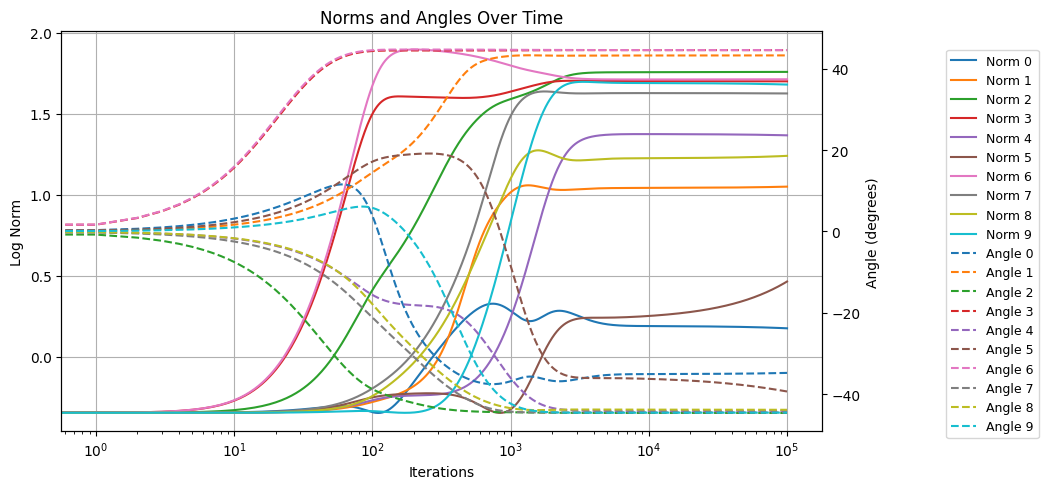

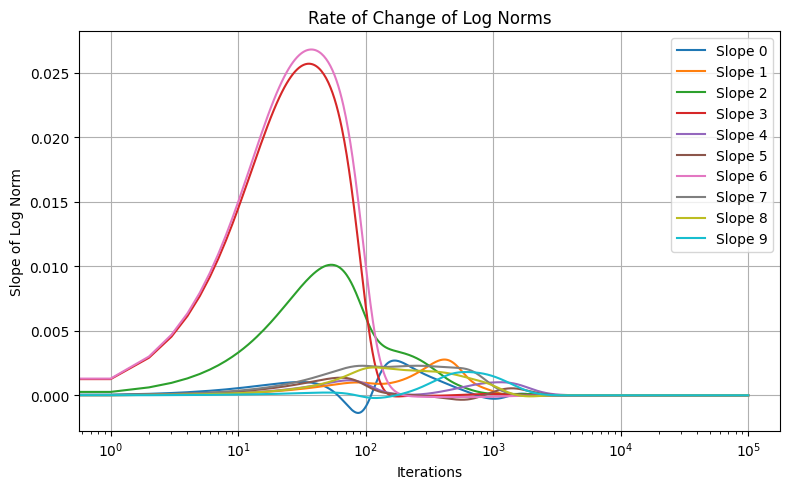

In [94]:
import numpy as np
import matplotlib.pyplot as plt

weight_list = np.array(weight_list)  # Ensure it's a NumPy array
num_iters, _, d = weight_list.shape  # Shape: (iterations, 2, d)

# Compute norms, slope, angles for each vector in d
norms = np.linalg.norm(weight_list, axis=1)  # Shape (num_iters, d)
slopes = np.gradient(np.log(norms), axis=0)  # Compute slope using finite differences
angles = np.degrees(np.arctan2(weight_list[:, 1, :], weight_list[:, 0, :]))  # Shape (num_iters, d)

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(9, 5))  # Slightly wider figure

# Plot norms on primary y-axis (log scale)
colors = plt.cm.tab10.colors  # Use distinct colors for each index
for i in range(d):
    ax1.plot(np.log(norms[:, i]), label=f'Norm {i}', color=colors[i % len(colors)], linestyle='-')

ax1.set_xlabel("Iterations")
ax1.set_ylabel("Log Norm", color="black")
ax1.tick_params(axis="y", labelcolor="black")
ax1.set_title("Norms and Angles Over Time")
ax1.grid()

# Create secondary y-axis for angles
ax2 = ax1.twinx()
for i in range(d):
    ax2.plot(angles[:, i], label=f'Angle {i}', color=colors[i % len(colors)], linestyle='--')

ax2.set_ylabel("Angle (degrees)", color="black")
ax2.tick_params(axis="y", labelcolor="black")
ax1.set_xscale('log')
# ax1.set_xlim(0, 20000)

# Combine legends from both axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# Place legend outside the plot (right side)
fig.legend(handles1 + handles2, labels1 + labels2, loc="center left", bbox_to_anchor=(1.05, 0.5), fontsize=9)

plt.tight_layout()
plt.show()

# Create figure
fig, ax = plt.subplots(figsize=(8, 5))

# Plot slopes of log-norms
colors = plt.cm.tab10.colors  # Use distinct colors
for i in range(d):
    ax.plot(slopes[:, i], label=f'Slope {i}', color=colors[i % len(colors)], linestyle='-')

ax.set_xlabel("Iterations")
ax.set_ylabel("Slope of Log Norm")
ax.set_title("Rate of Change of Log Norms")
ax.grid()
ax.set_xscale('log')
# ax.set_xlim(1e3, 1e5)
ax.legend(loc="upper right")

plt.tight_layout()
plt.show()

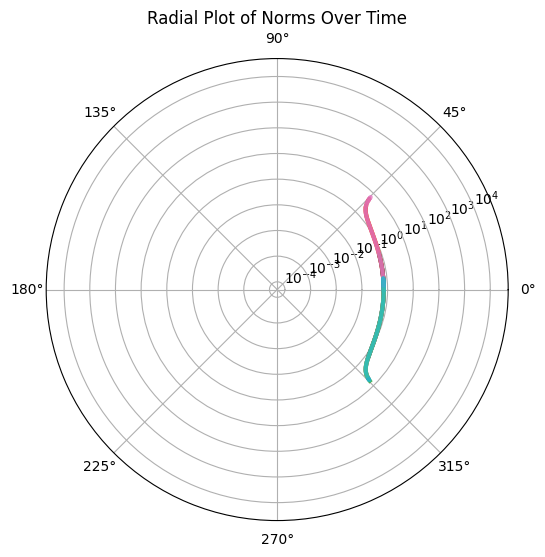

In [95]:
weight_list = np.array(weight_list)  # Ensure it's a NumPy array
num_iters, _, d = weight_list.shape  # Shape: (iterations, 2, d)

# Compute norms and angles for each vector in d
norms = np.linalg.norm(weight_list, axis=1)  # Shape (num_iters, d)
angles = np.arctan2(weight_list[:, 1, :], weight_list[:, 0, :])  # Radians

# Create radial plots for each coordinate
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 6))

colors = plt.cm.tab10.colors  # Use distinct colors for each coordinate
k = int(num_iters * 0.06)
for i in range(d):
    ax.plot(angles[:k, i], norms[:k, i], label=f'Coord {i}', color=colors[i % len(colors)], alpha=0.8, lw=3)

ax.set_ylim(1e-4 * alpha, 1e5 * alpha)
ax.set_yscale('log')
ax.set_title("Radial Plot of Norms Over Time")
# ax.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1))
plt.show()

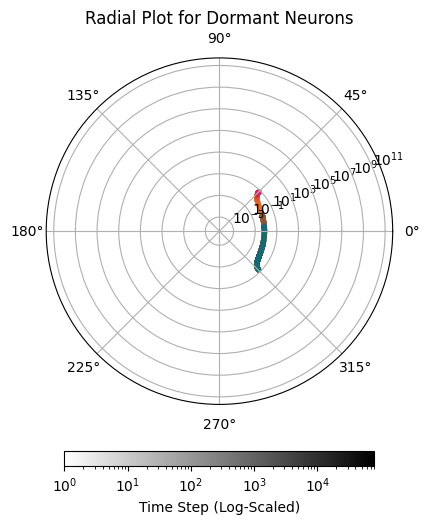

In [96]:
weight_list = np.array(weight_list)  # Ensure it's a NumPy array
num_iters, _, d = weight_list.shape  # Shape: (iterations, 2, d)

# Compute norms and angles for each vector in d
norms = np.linalg.norm(weight_list, axis=1)  # Shape (num_iters, d)
angles = np.arctan2(weight_list[:, 1, :], weight_list[:, 0, :])  # Radians

# **Step 1: Adaptive Downsampling Strategy**
# Logarithmic downsampling to capture rapid changes early and sparse updates later
num_iters = int(num_iters * 0.8)
num_plot_points = 10000  # Target number of plotted points
log_indices = np.unique(np.logspace(0, np.log10(num_iters - 1), num=num_plot_points, dtype=int))

# Extract downsampled data
angles_ds = angles[log_indices, :]
norms_ds = norms[log_indices, :]
times_ds = log_indices  # Use indices as time representation

# **Step 2: Create Radial Plot**
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 6))

# Create color maps for both time evolution and coordinate distinction
time_cmap = plt.cm.binary  # For time evolution (darkens over time)
coord_colors = plt.cm.tab10.colors  # Unique colors for each coordinate

# Normalize time for transparency effect
norm = matplotlib.colors.LogNorm(vmin=1, vmax=num_iters)
# norm = plt.Normalize(vmin=0, vmax=num_iters)

# Plot each coordinate with both time-gradient (darkening) and distinct colors
for i in range(d):
    # Convert time values into transparency levels (darker as time progresses)
    alpha_values = 0.0 * norm(times_ds + 1) * 0.9 + 0.01

    # Plot scatter points with coordinate-specific color but darkening over time
    ax.scatter(angles_ds[:, i], norms_ds[:, i], color=[(*coord_colors[i % len(coord_colors)], alpha) for alpha in alpha_values], s=10)


# Set radial limits and log scale
ax.set_ylim(1e-4 * alpha, 1e12 * alpha)
ax.set_yscale('log')

ax.set_title("Radial Plot for Dormant Neurons")

# **Step 3: Add a Colorbar for Time Evolution**
sm = plt.cm.ScalarMappable(cmap=time_cmap, norm=norm)
cbar = plt.colorbar(sm, ax=ax, orientation="horizontal", pad=0.1, shrink=0.5)
cbar.set_label("Time Step (Log-Scaled)")

plt.show()

## Succesive Saddle Algorthim from Pesme and Flammarion 2023

In [97]:
def constrained_minimization(s, X, y):
    """ Solves min_beta (1/2n) ||Xβ - y||^2 s.t. sign constraints from s using least squares """
    n, d = X.shape
    
    # Define initial bounds
    lower_bounds = np.full(d, -np.inf)  # Default to no lower bound
    upper_bounds = np.full(d, np.inf)   # Default to no upper bound
    
    # Apply constraints:
    lower_bounds[np.isclose(s, 1, atol=1e-9)] = 0 # β_i >= 0 if s_i = +1
    upper_bounds[np.isclose(s, -1, atol=1e-9)] = 0 # β_i <= 0 if s_i = -1
    
    # Fix β_i = 0 for all -1 < s < 1
    mask = ~np.isclose(s, 1, atol=1e-9) & ~np.isclose(s, -1, atol=1e-9)
    lower_bounds[mask] = -1e-10
    upper_bounds[mask] = 1e-10

    # Solve constrained least squares
    result = scipy.optimize.lsq_linear(X, y, bounds=(lower_bounds, upper_bounds), method='trf')

    return result.x 


# Implements Algorithm 1: Successive saddles and jump times
def successive_saddles(X, y, tol_grad=1e-9):
    t = 0.0
    beta = np.zeros(d)
    s = np.zeros(d)
    grad_beta = -y @ X

    loss_list = [0.5 * np.mean(y**2)]
    beta_list = [beta]
    t_list = [0]
    learned = []
        
    while np.linalg.norm(grad_beta) > tol_grad:
        # 1. Set A = { j | ∇L(β)_j ≠ 0 }
        A = np.where(np.abs(grad_beta) > tol_grad)[0]
    
        # 2. Compute ∆ as inf { δ > 0 | ∃ i in A, s(i) - δ∇L(β)(i) = ±1 }
        delta_candidates = []
        indices = []
        for i in A:
            g_i = grad_beta[i]
            for boundary in [+1, -1]:
                delta = (s[i] - boundary) / g_i
                if delta > 0:
                    delta_candidates.append(delta)
                    indices.append(i)
        delta = np.min(delta_candidates)
        idx = indices[np.argmin(delta_candidates)]
    
        # 3. Update (t, s)
        t += delta
        s -= delta * grad_beta
        s = np.clip(s, -1.0, 1.0)
    
        # 4. Compute β under sign constraints
        beta = constrained_minimization(s, X, y)
        residual = y - beta.T @ X.T
        grad_beta = -residual @ X
    
        # 5. Store results
        loss_list.append(0.5 * np.mean(residual**2))
        beta_list.append(beta.copy())
        t_list.append(t)
        learned.append(idx)

    print("Learned indices: {}".format(learned))
    return loss_list, beta_list, t_list

Learned indices: [6, 3, 2, 0, 1, 7, 8, 9, 4, 5]


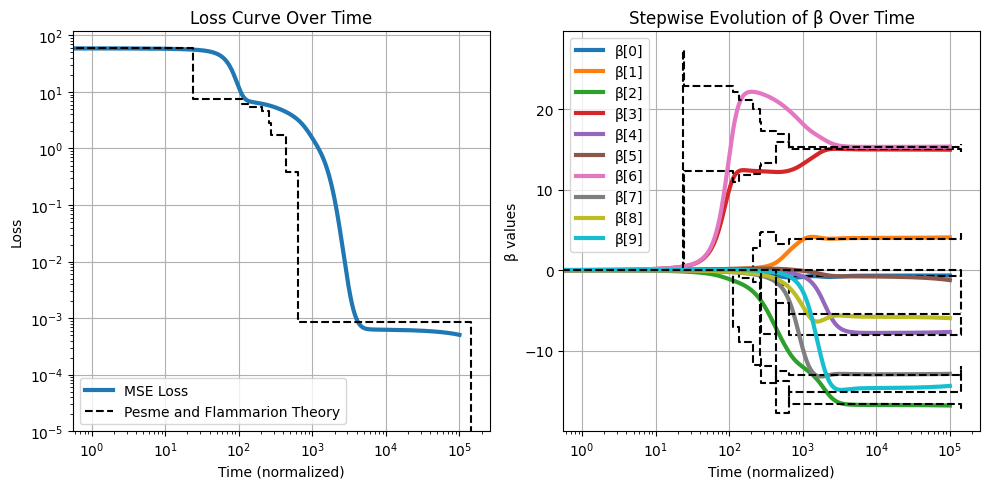

In [98]:
loss_list, beta_list, t_list = successive_saddles(X, y, tol_grad=1e-9)

betas = np.array(betas)   # shape (iterations, d)
beta_sequence = np.array(beta_list)  # Convert β list to an array (shape: [num_steps, d])
time_sequence = np.array(t_list) / learning_rate  # Normalize time
const = n * np.log(1/alpha) # WHY THIS CONSTANT (The n is b/c not normalizing gradient in successive saddles)

plt.figure(figsize=(10, 5))

# Subplot 1: Loss Curve
plt.subplot(1, 2, 1)
plt.plot(range(max_iters + 1), losses, label='MSE Loss', lw=3)
plt.step(time_sequence * const, loss_list, linestyle='--', color='k', where='post', label='Pesme and Flammarion Theory', lw=1.5)
plt.xlabel("Time (normalized)")
plt.ylabel("Loss")
plt.title("Loss Curve Over Time")
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-5, 2 * losses[0])
plt.grid()
plt.legend()


# Subplot 2: Stepwise β Evolution
plt.subplot(1, 2, 2)
d = beta_sequence.shape[1]  # Number of β coordinates
for i in range(d):
    plt.plot(range(max_iters + 1), betas[:, i], color=plt.get_cmap("tab10")(i), label=f'β[{i}]', lw=3)
    plt.step(time_sequence * const, beta_sequence[:, i], where='post', color='k', linestyle='--', lw=1.5)

plt.xlabel("Time (normalized)")
plt.ylabel("β values")
plt.title("Stepwise Evolution of β Over Time")
plt.xscale('log')
plt.grid()
plt.legend()

plt.tight_layout()  # Adjust layout for readability
plt.show()

In [92]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os

# Ensure 'gifs' directory exists
os.makedirs("gifs", exist_ok=True)

# Assume `loss_list`, `beta_list`, `t_list`, `learning_rate`, `n`, `alpha`, `max_iters`, `losses`, `betas` are preloaded.

# Convert lists to arrays
beta_sequence = np.array(beta_list)  # Shape: (num_steps_theory, d)
time_sequence_theory = np.array(t_list) * n * np.log(1 / alpha) / learning_rate  # Normalize theoretical time
d = beta_sequence.shape[1]  # Number of β coordinates
num_steps_theory = len(loss_list)  # Number of theory steps
num_steps_empirical = len(losses)  # Number of empirical time points

# Ensure empirical time aligns with theoretical range
time_sequence_empirical = np.linspace(1, max_iters + 1, num_steps_empirical)

# Logarithmic subsampling for smooth animation (max ~100 frames)
num_frames = min(100, num_steps_empirical)
frame_indices = [0] + np.unique(np.round(np.logspace(0, np.log10(num_steps_empirical - 1), num_frames)).astype(int))

# Subsample empirical data
time_sequence_empirical = time_sequence_empirical[frame_indices]
losses_sampled = np.array(losses)[frame_indices]
betas_sampled = np.array(betas)[frame_indices]

### LOSS CURVE ANIMATION ###
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("Time (normalized)")
ax.set_ylabel("Loss")
ax.set_title("Loss Curve Over Time")
ax.grid()
ax.set_ylim(1e-5, 2 * losses[0])
ax.set_xlim(1, time_sequence_theory[-1])

# **Initialize empirical plot elements**
(loss_line,) = ax.plot([], [], "b", lw=3, label="Empirical MSE Loss")
ax.legend()

# **Plot theory as static background**
ax.step(time_sequence_theory, loss_list, linestyle="--", color="k", where="post", lw=1.5, label="Pesme & Flammarion Theory")

def update_loss(frame):
    # Update empirical loss curve
    loss_line.set_data(time_sequence_empirical[:frame], losses_sampled[:frame])
    return loss_line,

ani_loss = animation.FuncAnimation(fig, update_loss, frames=len(frame_indices), interval=50, blit=True)
ani_loss.save("gifs/loss_curve.gif", writer="pillow", fps=20)
plt.close(fig)

### BETA EVOLUTION ANIMATION ###
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_xscale('log')
ax.set_xlabel("Time (normalized)")
ax.set_ylabel("Beta values")
ax.set_title("Stepwise Evolution of Beta Over Time")
ax.set_xlim(1, time_sequence_theory[-1])
ax.grid()

# **Initialize empirical plot elements**
beta_lines = [ax.plot([], [], color=plt.get_cmap("tab10")(i), lw=3, label=f'β[{i}]')[0] for i in range(d)]

# **Plot theory as static background for all β coordinates, but only one legend entry**
for i in range(d):
    ax.step(time_sequence_theory, beta_sequence[:, i], where="post", color="k", linestyle="--", lw=1.5)
theory_legend_handle, = ax.plot([], [], "k--", lw=1.5, label="Theory β")  # Single legend entry

# **Create a separate legend figure**
legend_fig, legend_ax = plt.subplots(figsize=(4, 6))
legend_ax.axis("off")
handles = beta_lines + [theory_legend_handle]  # Only one legend entry for theory
labels = [f'β[{i}]' for i in range(d)] + ["Theory β"]
legend_ax.legend(handles, labels, loc="center", frameon=False)

# Save legend as a PDF
legend_fig.savefig("gifs/beta_legend.pdf", bbox_inches="tight")
plt.close(legend_fig)

def update_beta(frame):
    for i, line in enumerate(beta_lines):
        line.set_data(time_sequence_empirical[:frame], betas_sampled[:frame, i])
    return beta_lines

ani_beta = animation.FuncAnimation(fig, update_beta, frames=len(frame_indices), interval=50, blit=True)
ani_beta.save("gifs/beta_evolution.gif", writer="pillow", fps=20)
plt.close(fig)

print("GIFs saved in 'gifs/' directory: loss_curve.gif, beta_evolution.gif, beta_legend.pdf")

GIFs saved in 'gifs/' directory: loss_curve.gif, beta_evolution.gif, beta_legend.pdf


## Utility Maximization Framework

In [81]:
# Initialization
t = 0.0
residual = y
dormant, active = [i for i in range(d)], []
lognorms = np.log(np.sqrt(2) * alpha) * np.ones(d)

# Statistics to track
step = 0
levels = [0.5 * np.mean(residual**2)]
times = [t]
coefs = [np.zeros(d)]

while len(dormant) > 0:

    # Step 1: Compute Maximal Utility
    sigma_yx = residual @ X / n
    u_max = np.abs(sigma_yx) / 2

    # Step 2: Determine next neuron
    tau_candidates = [-lognorms[i] / (2 * u_max[i]) for i in dormant]
    tau = np.min(tau_candidates)
    idx = dormant[np.argmin(tau_candidates)]
    
    # 3. Update (t, norms, dormant and active)
    active.append(idx)
    dormant.remove(idx)
    t += tau
    # THIS STEP NEEDS TO CHANGE. NEED TO ACCOUNT FOR A POSSIBLE DIRECTIONAL CHANGE FROM PREVIOUS STEP 
    # (sometimes norm decreases before increases)
    lognorms[dormant] += tau * 2 * u_max[dormant]
    
    # 4. Compute new beta
    U_max = (y @ X)[active]
    C_min = X[:, active].T @ X[:, active]
    new_beta = np.linalg.pinv(C_min) @ U_max
    beta = np.zeros(d)
    beta[active] = new_beta

    # Step 3: Check for sign changes, remove flipped indices, and recompute beta
    sign_changes = [i for i in active if beta[i] * coefs[-1][i] < 0]
    if sign_changes:
        for i in sign_changes:
            active.remove(i)
            dormant.append(i)
        # lognorms[sign_changes] = np.log(np.sqrt(2) * alpha) # WHAT IS THE CORRECT REINITIALIZATION?
        U_max = (y @ X)[active]
        C_min = X[:, active].T @ X[:, active]
        beta = np.zeros(d)
        beta[active] = np.linalg.pinv(C_min) @ U_max
        print("Active neurons {} became dormant".format(sign_changes))

    # Step 4: Update residual and store results
    step += 1
    residual = y - X @ beta
    levels.append(0.5 * np.mean(residual**2))
    times.append(t)
    coefs.append(beta.copy())
    print(f"Step {step}: time: {round(t,3)}, active {active}")

Step 1: time: 23.35, active [6]
Step 2: time: 23.937, active [6, 3]
Step 3: time: 110.47, active [6, 3, 2]
Step 4: time: 114.392, active [6, 3, 2, 0]
Step 5: time: 199.986, active [6, 3, 2, 0, 1]
Step 6: time: 256.461, active [6, 3, 2, 0, 1, 7]
Step 7: time: 284.068, active [6, 3, 2, 0, 1, 7, 8]
Step 8: time: 359.86, active [6, 3, 2, 0, 1, 7, 8, 9]
Step 9: time: 700.964, active [6, 3, 2, 0, 1, 7, 8, 9, 4]
Step 10: time: 83150.2, active [6, 3, 2, 0, 1, 7, 8, 9, 4, 5]


In [82]:
# Convert Pesme's algorithm times
pesme_times = np.log(1 / alpha) * np.array(t_list) * n

# Print table header
print(f"{'Step':<10}{'Pesmes Algorithm':<20}{'Approx Util Maximization':<20}")
print("-" * 50)

# Print each step's values
for i in range(len(pesme_times)):
    print(f"{i+1:<10}{pesme_times[i]:<20.6f}{times[i]:<20.6f}")

Step      Pesmes Algorithm    Approx Util Maximization
--------------------------------------------------
1         0.000000            0.000000            
2         23.467904           23.350161           
3         24.057421           23.936721           
4         111.026971          110.469931          
5         136.507447          114.391866          
6         207.983266          199.985656          
7         259.099305          256.460799          
8         270.253838          284.067607          
9         434.426721          359.859515          
10        643.979782          700.963550          
11        141606.358536       83150.200332        


## Exact Utility Maximization Framework
This uses exact expressions for the accumulated integral. The issue is this code is very numerically unstable for extremely small choices of $\alpha$. That said, it matches perfectly Pesme and Flamaraion results and should actually be able to capture the non-stepwise behavior if we want!

In [83]:
# Initialization
residual = y
dormant, active = [i for i in range(d)], []
scale = np.sqrt(2) * alpha 
t = 0.0
norm = scale * np.ones(d)
sgns = np.zeros(d)

# Statistics to track
step = 0
levels = [0.5 * np.mean(residual**2)]
times = [t]
coefs = [np.zeros(d)]

while len(dormant) > 0:

    # 1. Compute Max Utility
    grad_beta = -residual @ X / n
    max_util = np.array([np.abs(grad_beta[i]) / 2 for i in dormant])
    sigma = np.array([sgns[i] * np.sign(grad_beta[i]) for i in dormant])
    c = sigma * np.array([np.arccosh(norm[i]**2 / scale**2) for i in dormant])

    # 2. Compute taus
    tau_candidates = (np.arccosh(1/scale**2) - c) / (4 * max_util)

    # 3. Next emergent neuron
    tau = np.min(tau_candidates)
    idx = dormant[np.argmin(tau_candidates)]
    
    # 4. Update norm, sgns, t
    norm[dormant] = scale * np.sqrt(np.cosh(4 * max_util * tau + c))
    sgns[dormant] = np.sign(4 * max_util * tau + c) * np.sign(grad_beta[dormant])
    t += tau
    active.append(idx)
    dormant.remove(idx)
    
    # 5. Compute new beta
    U_max = (y @ X)[active]
    C_min = X[:, active].T @ X[:, active]
    new_beta = np.linalg.pinv(C_min) @ U_max
    beta = np.zeros(d)
    beta[active] = new_beta

    # 6. Check for sign changes, remove flipped indices, and recompute beta
    sign_changes = [i for i in active if beta[i] * coefs[-1][i] < 0]
    if sign_changes:
        for i in sign_changes:
            active.remove(i)
            dormant.append(i)
        # lognorms[sign_changes] = np.log(np.sqrt(2) * alpha) # WHAT IS THE CORRECT REINITIALIZATION?
        U_max = (y @ X)[active]
        C_min = X[:, active].T @ X[:, active]
        beta = np.zeros(d)
        beta[active] = np.linalg.pinv(C_min) @ U_max
        print("Active neurons {} became dormant".format(sign_changes))

    # 7. Update residual and store results
    step += 1
    residual = y - X @ beta
    levels.append(0.5 * np.mean(residual**2))
    times.append(t)
    coefs.append(beta.copy())
    print(f"Step {step}: time: {round(t,3)}, active {active}")

Step 1: time: 23.468, active [6]
Step 2: time: 24.057, active [6, 3]
Step 3: time: 111.027, active [6, 3, 2]
Step 4: time: 136.507, active [6, 3, 2, 0]
Step 5: time: 207.983, active [6, 3, 2, 0, 1]
Step 6: time: 259.099, active [6, 3, 2, 0, 1, 7]
Step 7: time: 270.254, active [6, 3, 2, 0, 1, 7, 8]
Step 8: time: 434.427, active [6, 3, 2, 0, 1, 7, 8, 9]
Step 9: time: 643.98, active [6, 3, 2, 0, 1, 7, 8, 9, 4]
Step 10: time: 141606.359, active [6, 3, 2, 0, 1, 7, 8, 9, 4, 5]


In [84]:
# Convert Pesme's algorithm times
pesme_times = np.log(1 / alpha) * np.array(t_list) * n

# Print table header
print(f"{'Step':<10}{'PF 2023':<20}{'AGF':<20}")
print("-" * 50)

# Print each step's values
for i in range(len(pesme_times)):
    print(f"{i+1:<10}{pesme_times[i]:<20.6f}{times[i]:<20.6f}")

Step      PF 2023             AGF                 
--------------------------------------------------
1         0.000000            0.000000            
2         23.467904           23.467904           
3         24.057421           24.057421           
4         111.026971          111.026971          
5         136.507447          136.507447          
6         207.983266          207.983266          
7         259.099305          259.099305          
8         270.253838          270.253838          
9         434.426721          434.426721          
10        643.979782          643.979782          
11        141606.358536       141606.358535       


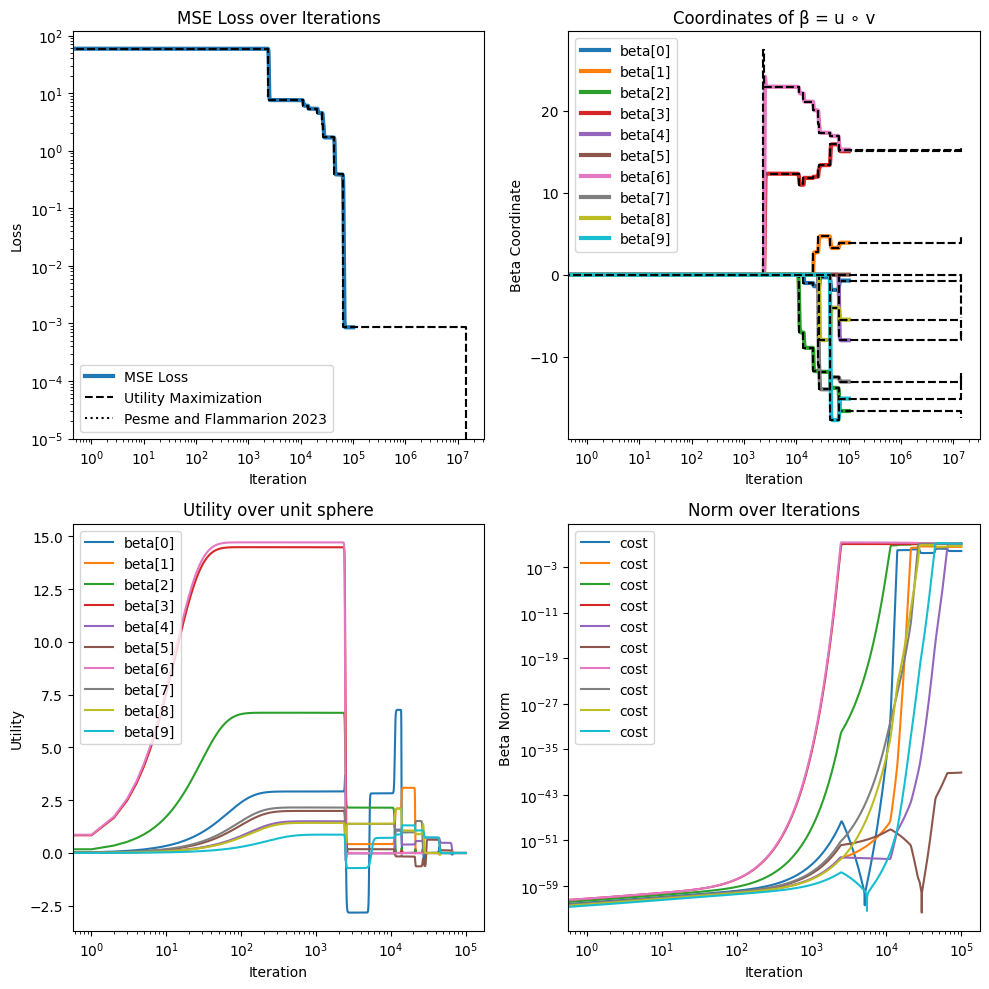

Final iteration: 100000
Final parameters:


NameError: name 'u' is not defined

In [85]:
# -------------------------------
# 5. Plot Results
# -------------------------------
iterations = len(losses)

plt.figure(figsize=(10, 10))

# (a) Plot the MSE loss over iterations
plt.subplot(2, 2, 1)
plt.plot(range(iterations), losses, label='MSE Loss', lw=3)
plt.step(np.array(times) / learning_rate, levels, linestyle='--', color='k', where='post', label='Utility Maximization', lw=1.5)
plt.step(time_sequence * const, loss_list, linestyle=':', color='k', where='post', label='Pesme and Flammarion 2023', lw=1.5)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('MSE Loss over Iterations')
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-5, 2 * losses[0])
plt.legend()

# for level in levels:
#     plt.axhline(y=level, color='gray', linestyle='dotted', linewidth=2)


# (b) Plot each coordinate of beta over iterations
betas = np.array(betas)   # shape (iterations, d)
coefs = np.array(coefs)
for coord in range(d):
    plt.subplot(2, 2, 2)
    plt.plot(range(iterations), betas[:, coord], label=f'beta[{coord}]', lw=3)
    plt.step(np.array(times) / learning_rate, coefs[:, coord], where='post', color='k', linestyle='--', lw=1.5)
    plt.step(time_sequence * const, beta_sequence[:, coord], where='post', color='k', linestyle=':', lw=1.5)
plt.xlabel('Iteration')
plt.ylabel('Beta Coordinate')
plt.title('Coordinates of β = u ∘ v')
# plt.yscale('log')
plt.xscale('log')
plt.legend()


# (c) Plot utility for each neuron
weight_list = np.array(weight_list)
betas = np.array(betas)   # shape (iterations, d)
residual = y - betas @ X.T
beta_grad = residual @ X
for i in range(d):
    plt.subplot(2, 2, 3)
    f_i = np.prod(weight_list[:,:,i], axis=1) / np.linalg.norm(weight_list[:,:,i], axis=1)**2
    utility = f_i * beta_grad[:, i]
    plt.plot(range(iterations), utility, label=f'beta[{i}]')
plt.xlabel('Iteration')
plt.ylabel('Utility')
plt.title('Utility over unit sphere')
plt.xscale('log')
# plt.ylim(-1e2 * alpha, 1e4 * alpha)
plt.legend()


# (d) Plot cost
betas = np.array(betas)   # shape (iterations, d)
for coord in range(d):
    cost = np.abs(betas[:, coord])
    plt.subplot(2, 2, 4)
    plt.plot(range(iterations), cost, label='cost')
plt.xlabel('Iteration')
plt.ylabel('Beta Norm')
plt.title('Norm over Iterations')
plt.yscale('log')
plt.xscale('log')
plt.legend()




plt.tight_layout()
plt.show()

# -------------------------------
# 6. Print Final Results
# -------------------------------
final_loss = losses[-1]
print(f"Final iteration: {iterations - 1}")
print("Final parameters:")
print("u =", u)
print("v =", v)
print("Final MSE loss =", final_loss)
print("Final beta =", u * v)
print("True beta =", beta_true)